![Alt text](doc/didymosnet-logo.gif)

# Getting started

First, download the required packages:

```
pip install numpy torch torchvision matplotlib opencv-python
```

Next, the pretrained models can be downloaded by running the following cell:

In [ ]:
# DidymosNet
! mkdir -p pretrained/didymosnet && cd pretrained/didymosnet && wget https://www.dropbox.com/s/fjdwvoymbivu0fq/net-epoch-200.pth

# DidymosNet$^\pm$
! mkdir -p pretrained/didymosnet_pm && cd pretrained/didymosnet_pm && wget https://www.dropbox.com/s/00tuxbpa9olyafz/net-epoch-200.pth

# DidymosNet$^{\pm'}$
! mkdir -p pretrained/didymosnet_pmp && cd pretrained/didymosnet_pmp && wget https://www.dropbox.com/s/d8qkb17wjx4odvs/net-epoch-200.pth

# Feature extraction and matching demo

Here we demonstrate feature extraction and matching using DidymosNet on an example image pair from the OSIRIS-REx mission to Asteroid 101955 Bennu provided through the [AstroVision dataset](https://github.com/astrovision).

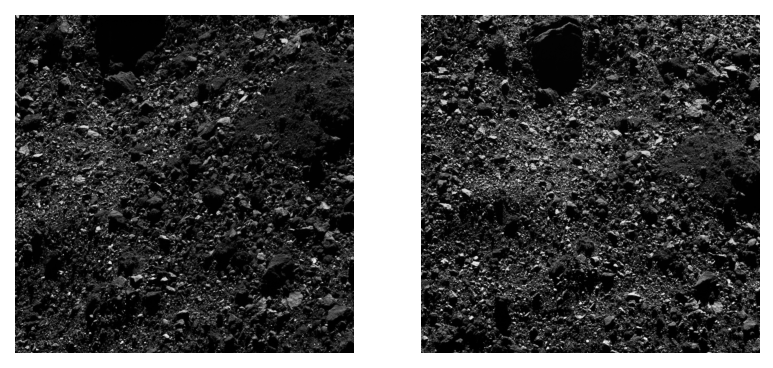

In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from models.didymosnet import DidymosNet

matplotlib.rcParams["figure.dpi"] = 150

# Read in example images.
img0 = cv2.cvtColor(cv2.imread("data/orex_bennu/00004614.png"), cv2.COLOR_BGR2GRAY)[..., np.newaxis]
img1 = cv2.cvtColor(cv2.imread("data/orex_bennu/00000509.png"), cv2.COLOR_BGR2GRAY)[..., np.newaxis]

# Show images.
plt.subplot(121)
plt.imshow(img0, cmap="gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(img1, cmap="gray")
plt.axis("off")
plt.show()

## SIFT vs. DoG + DidymosNet

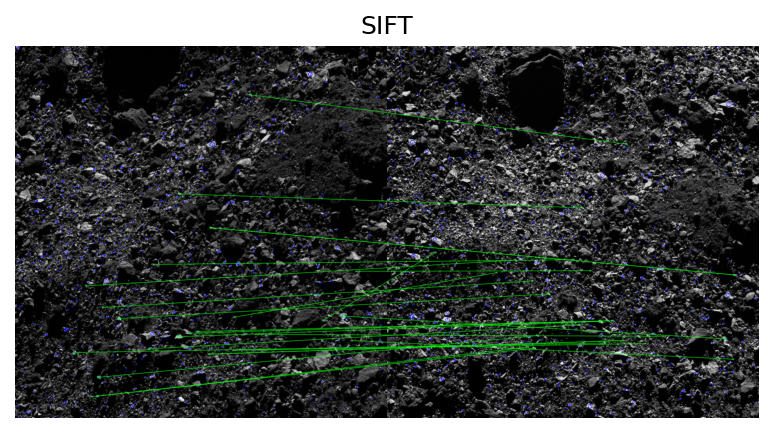

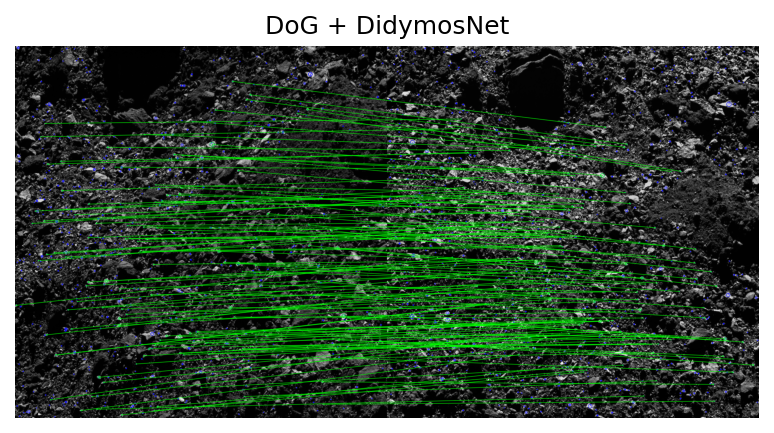

In [2]:
from utils.helper_funcs import extract_patches
from utils.opencv_helper import MatcherWrapper

# Load pretrained DidymosNet model.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DidymosNet(dim_desc=128)
model.load_state_dict(torch.load("pretrained/didymosnet/net-epoch-200.pth", map_location=device))
model.to(device).eval()

# Initialize matcher.
matcher = MatcherWrapper()

# Compute and match SIFT keypoints and descriptors.
sift = cv2.SIFT_create(nfeatures=1000)
kps0, sift_descs0 = sift.detectAndCompute(img0, None)
kps1, sift_descs1 = sift.detectAndCompute(img1, None)
sift_matches, _, _, sift_inlier_mask, _= matcher.get_matches(sift_descs0, sift_descs1, kps0, kps1)
disp = matcher.draw_matches(img0, kps0, img1, kps1, sift_matches, sift_inlier_mask)
plt.imshow(disp)
plt.title(r"SIFT")
plt.axis("off")
plt.show()

# Compute and match DidymosNet descriptors from SIFT (DoG) keypoints.
didymosnet_descs0 = model(extract_patches(img0, kps0, mag_factor=16).to(device)).cpu().detach().numpy()
didymosnet_descs1 = model(extract_patches(img1, kps1, mag_factor=16).to(device)).cpu().detach().numpy()
didymosnet_matches, _, _, didymosnet_inlier_mask, _= matcher.get_matches(didymosnet_descs0, didymosnet_descs1, kps0, kps1)
disp = matcher.draw_matches(img0, kps0, img1, kps1, didymosnet_matches, didymosnet_inlier_mask)
plt.imshow(disp)
plt.title(r"DoG + DidymosNet")
plt.axis("off")
plt.show()


## ORB vs. FAST + DidymosNet $^\pm$

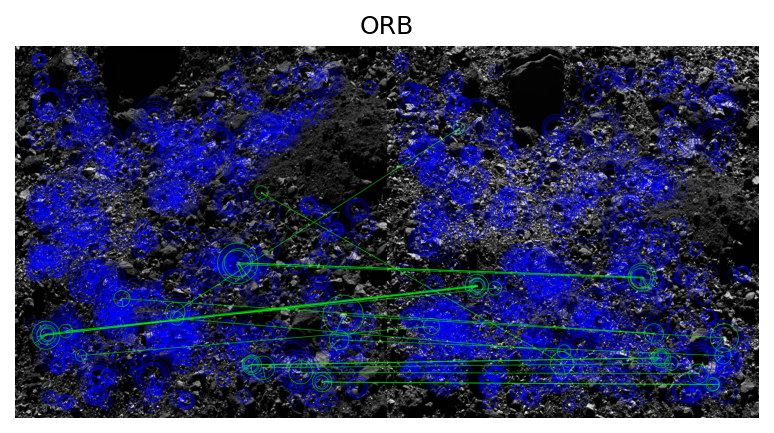

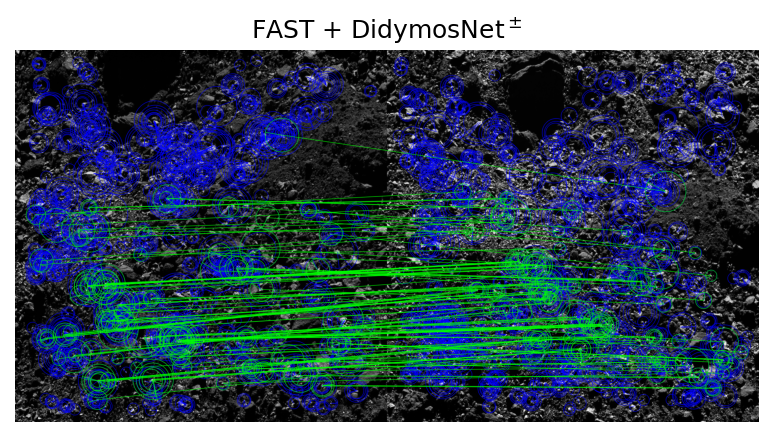

In [3]:
from utils.helper_funcs import extract_patches
from utils.opencv_helper import MatcherWrapper

# Load pretrained DidymosNet model.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DidymosNet(dim_desc=-1)
model.load_state_dict(torch.load("pretrained/didymosnet_pm/net-epoch-200.pth", map_location=device))
model.to(device).eval()

# Initialize matcher.
matcher = MatcherWrapper(norm_type=cv2.NORM_HAMMING)

# Compute and match ORB keypoints and descriptors.
orb = cv2.ORB_create(nfeatures=1000)
kps0, orb_descs0 = orb.detectAndCompute(img0, None)
kps1, orb_descs1 = orb.detectAndCompute(img1, None)
# orb_descs0 = np.unpackbits(orb_descs0, axis=1)
orb_matches, _, _, orb_inlier_mask, _= matcher.get_matches(orb_descs0, orb_descs1, kps0, kps1)
disp = matcher.draw_matches(img0, kps0, img1, kps1, orb_matches, orb_inlier_mask)
plt.imshow(disp)
plt.title(r"ORB")
plt.axis("off")
plt.show()

# Compute and match DidymosNet$^\pm$ descriptors from ORB (FAST) keypoints.
didymosnet_descs0 = model(extract_patches(img0, kps0, mag_factor=1).to(device)).cpu().detach().numpy()
didymosnet_descs1 = model(extract_patches(img1, kps1, mag_factor=1).to(device)).cpu().detach().numpy()
didymosnet_descs0 = ((16 * didymosnet_descs0 + 1) // 2).astype(np.uint8)  # convert to 0 or 1
didymosnet_descs1 = ((16 * didymosnet_descs1 + 1) // 2).astype(np.uint8)  # convert to 0 or 1
didymosnet_matches, _, _, didymosnet_inlier_mask, _= matcher.get_matches(didymosnet_descs0, didymosnet_descs1, kps0, kps1)
disp = matcher.draw_matches(img0, kps0, img1, kps1, didymosnet_matches, didymosnet_inlier_mask)
plt.imshow(disp)
plt.title(r"FAST + DidymosNet$^\pm$")
plt.axis("off")
plt.show()
